### Explore disease validation datasets

In [20]:
import os
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import typing as t
import pickle
import logging

from collections import defaultdict
from tqdm.auto import tqdm

# To suppress the stupid AnnData warning ...
warnings.filterwarnings("ignore", category=UserWarning, message="Transforming to str index.")

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext

sc.set_figure_params(figsize=(4, 4))

In [7]:
root_path = "/home/mehrtash/data"
val_adata_root_path = os.path.join(root_path, "data", "cellariumgpt_validation")
metadata_prediction_root_path = os.path.join(root_path, "data", "metadata_prediction_high__8192_with_XY_deep")

# these are the validation datasets we have precomputed metadata for
manifest = [
    ("4", "small intestine", "Crohn disease"),
    ("7", "small intestine", "Crohn disease"),
    ("22", "brain", "COVID-19"),
    ("23", "brain", "COVID-19"),
    ("24", "brain", "COVID-19"),
    ("29", "brain", "amyotrophic lateral sclerosis"),
    ("30", "blood", "common variable immunodeficiency"),
    ("31", "blood", "common variable immunodeficiency"),
    ("32", "blood", "common variable immunodeficiency"),
    ("59", "brain", "amyotrophic lateral sclerosis"),
    ("67", "lung", "COVID-19"),
    ("71", "brain", "amyotrophic lateral sclerosis"),
    ("75", "blood", "COVID-19"),
    ("81", "blood", "post-COVID-19 disorder"),
    ("82", "blood", "post-COVID-19 disorder"),
    ("83", "blood", "post-COVID-19 disorder"),
    ("94", "blood", "COVID-19"),
    ("95", "blood", "COVID-19"),
    ("103", "small intestine", "Crohn disease"),
    ("107", "lung", "COVID-19"),
    ("108", "lung", "COVID-19"),
]

In [85]:
manifest_df = pd.DataFrame(manifest, columns=["dataset_id", "tissue", "condition"])
display(manifest_df)

,dataset_id,tissue,condition
0,4,small intestine,Crohn disease
1,7,small intestine,Crohn disease
2,22,brain,COVID-19
3,23,brain,COVID-19
4,24,brain,COVID-19
5,29,brain,amyotrophic lateral sclerosis
6,30,blood,common variable immunodeficiency
7,31,blood,common variable immunodeficiency
8,32,blood,common variable immunodeficiency
9,59,brain,amyotrophic lateral sclerosis


#### Run standard scanpy preprocessing

In [9]:
from tqdm.auto import tqdm

for row in tqdm(manifest):

    val_adata_id = row[0]
    val_adata_path = os.path.join(val_adata_root_path, f"extract_{val_adata_id}.h5ad")
    adata = sc.read_h5ad(val_adata_path)

    adata.layers['counts'] = adata.X.copy()

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)

    adata = adata[:, adata.var['highly_variable']]

    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata, n_comps=50)
    sc.pp.neighbors(adata, n_pcs=50, n_neighbors=30)
    sc.tl.umap(adata)

    adata.write_h5ad(os.path.join(val_adata_root_path, f"extract_{val_adata_id}_pp.h5ad"))

  0%|          | 0/21 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy

#### Visualize

In [96]:
manifest_df

,dataset_id,tissue,condition
0,4,small intestine,Crohn disease
1,7,small intestine,Crohn disease
2,22,brain,COVID-19
3,23,brain,COVID-19
4,24,brain,COVID-19
5,29,brain,amyotrophic lateral sclerosis
6,30,blood,common variable immunodeficiency
7,31,blood,common variable immunodeficiency
8,32,blood,common variable immunodeficiency
9,59,brain,amyotrophic lateral sclerosis


In [247]:
manifest_idx = 15

val_adata_id = manifest[manifest_idx][0]

# load the preprocessed adata
val_adata_path = os.path.join(val_adata_root_path, f"extract_{val_adata_id}_pp.h5ad")
adata = sc.read_h5ad(val_adata_path)

# load the metadata prediction
meta_adata_path = os.path.join(
    metadata_prediction_root_path, f"extract_{val_adata_id}_metadata_prediction_scores.h5ad")
meta_adata = sc.read_h5ad(meta_adata_path)

assert adata.n_obs == meta_adata.n_obs

In [248]:
# align and transfer the metadata
adata = adata[meta_adata.obs.index].copy()
for key in meta_adata.obsm.keys():
    adata.obsm[key] = meta_adata.obsm[key]
for key in meta_adata.uns.keys():
    adata.uns[key] = meta_adata.uns[key]

In [249]:
# top_k predictions
top_k = 5

for metadata_key in ["disease", "tissue", "cell_type", "sex"]:
    logits_nk = adata.obsm[f"{metadata_key}_class_logits"]
    top_k_indices_nk = np.argsort(logits_nk, axis=1)[:, -top_k:][:, ::-1]
    for k in range(top_k_indices_nk.shape[-1]):
        adata.obs[f"{metadata_key}_top_{k+1}_label"] = adata.uns[f"{metadata_key}_labels"][top_k_indices_nk[:, k]]
        adata.obs[f"{metadata_key}_top_{k+1}_score"] = logits_nk[np.arange(logits_nk.shape[0]), top_k_indices_nk[:, k]]

In [250]:
# disease score
from scipy.special import logsumexp

disease_logits_nk = adata.obsm["disease_class_logits"]
disease = adata.obs["disease"].values[0]
disease_label_to_code_map = {label: code for code, label in enumerate(adata.uns["disease_labels"])}
assert disease in disease_label_to_code_map
disease_code = disease_label_to_code_map[disease]
normal_code = disease_label_to_code_map["normal"]
assert normal_code == 0  # sanity check

disease_logits_n2 = np.zeros((disease_logits_nk.shape[0], 2))
disease_logits_n2[:, 0] = disease_logits_nk[:, normal_code]
disease_logits_n2[:, 1] = disease_logits_nk[:, disease_code]
disease_logits_n2 = disease_logits_n2 - logsumexp(disease_logits_n2, axis=1)[:, None]

adata.obs["disease_score"] = disease_logits_n2[:, 1]

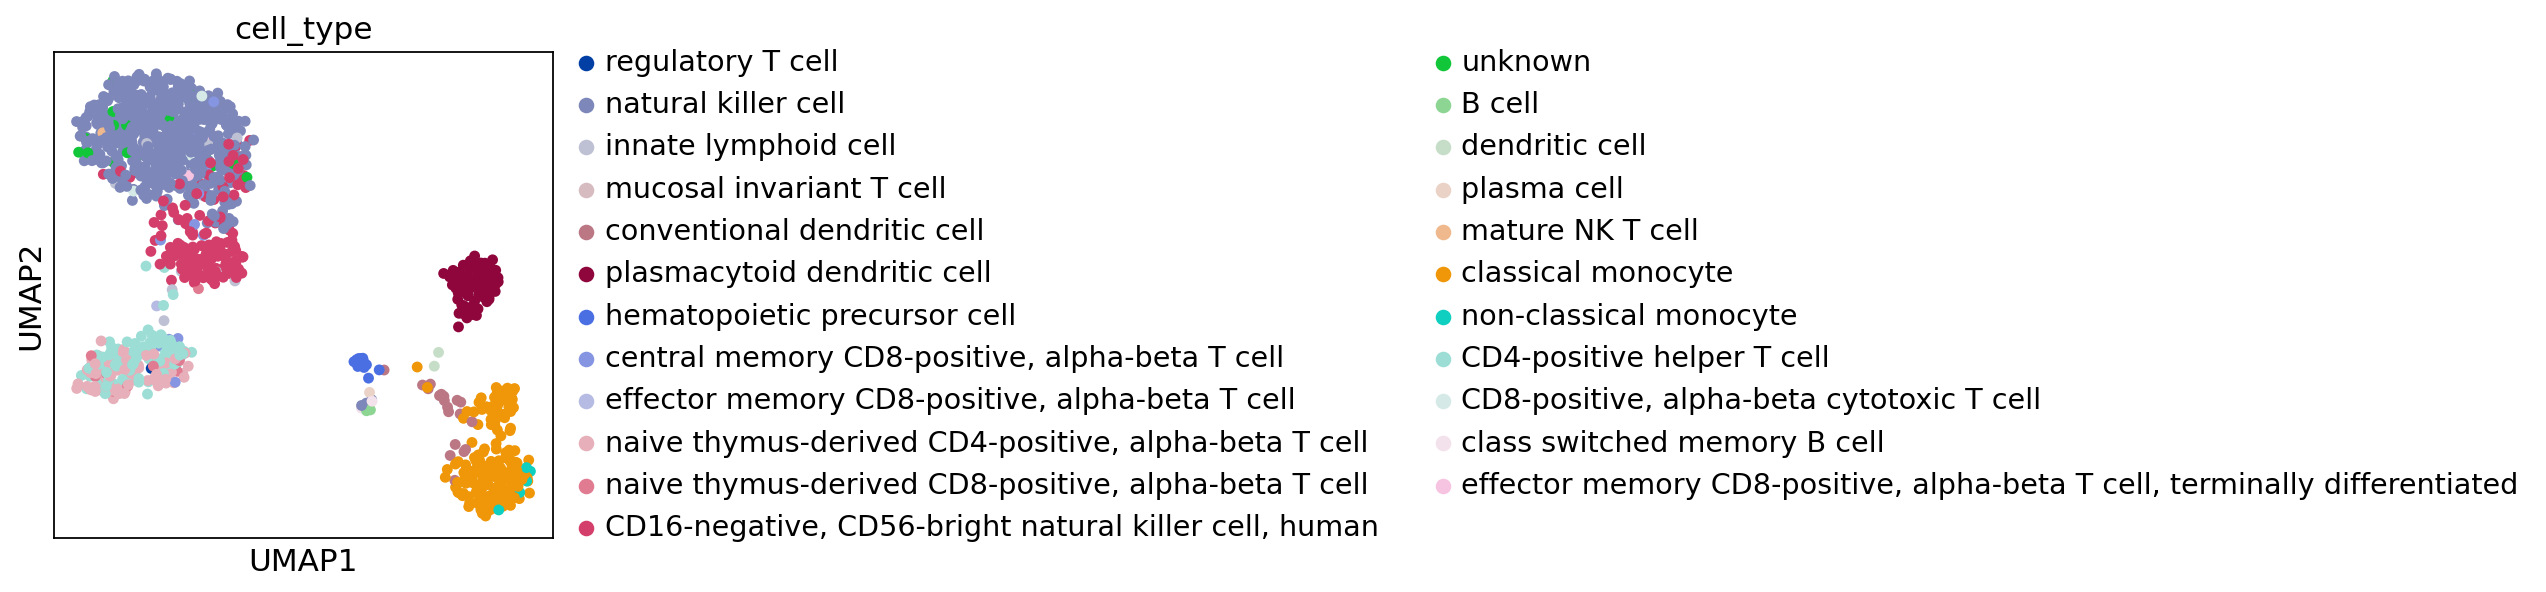

In [251]:
sc.pl.umap(adata, color='cell_type')

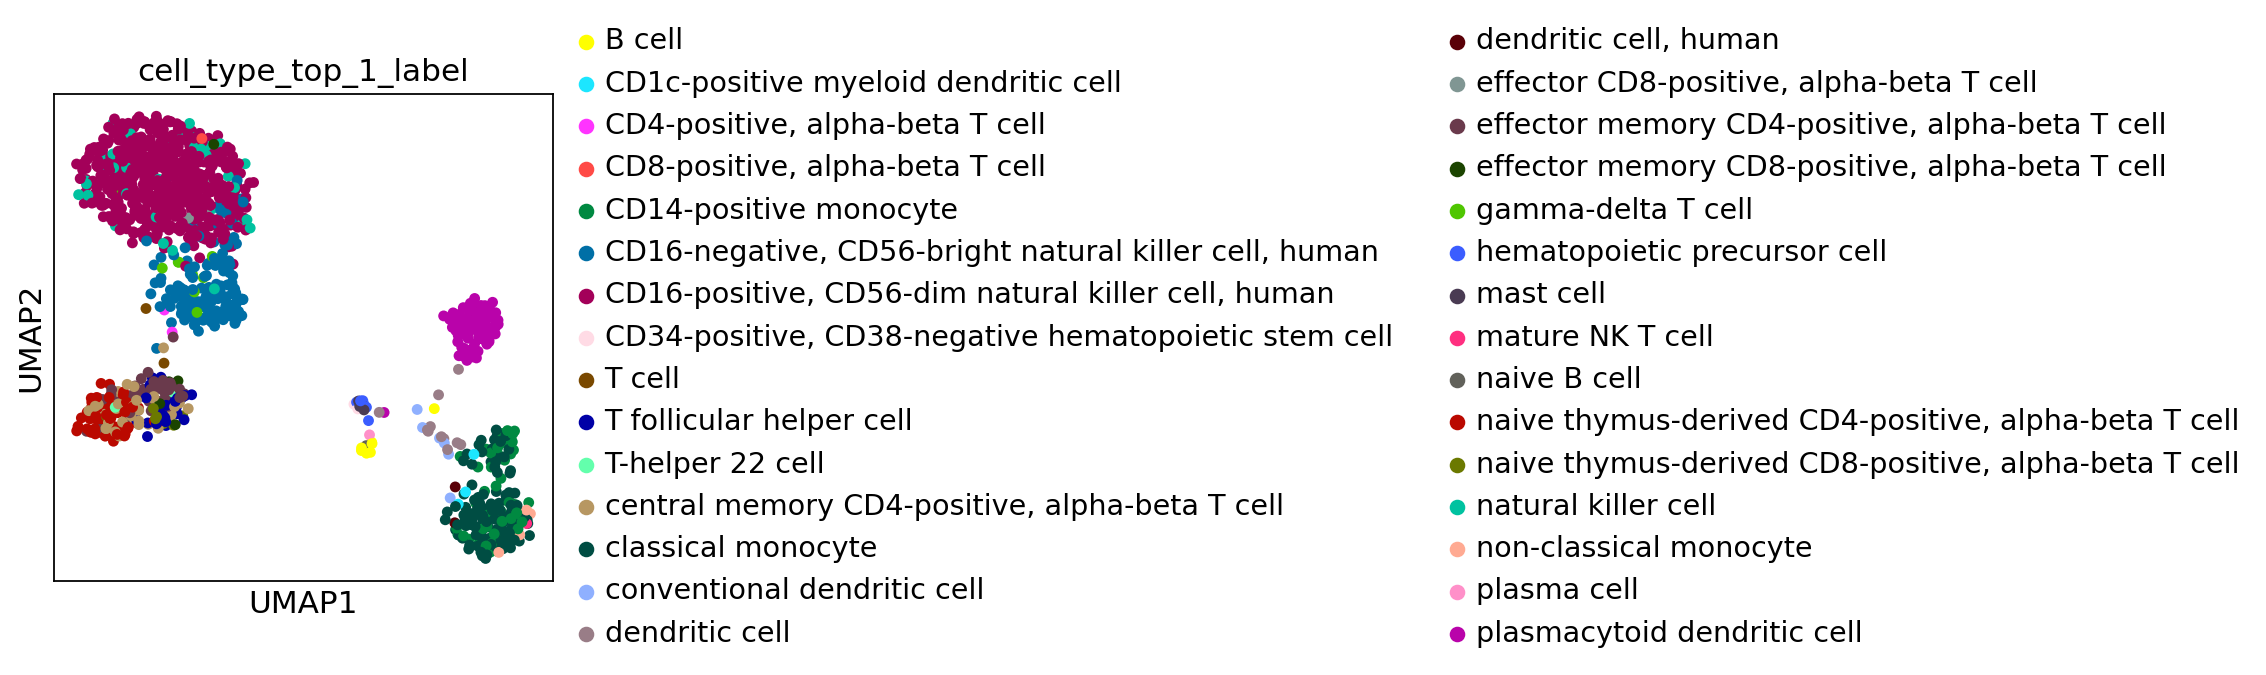

In [252]:
sc.pl.umap(adata, color='cell_type_top_1_label')

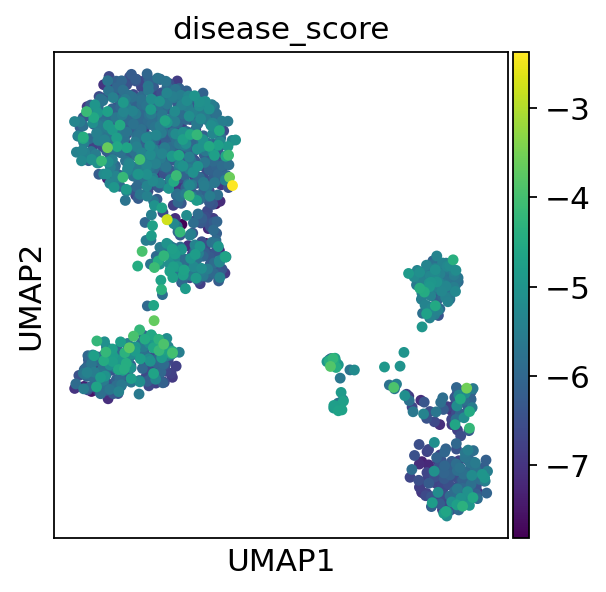

In [253]:
sc.pl.umap(adata, color='disease_score')

In [254]:
import plotly.express as px
import colorcet as cc
import pandas as pd


def generate_interactive_plotly_for_metadata(
        adata: sc.AnnData,
        top_k: int,
        metadata_key: str,
        use_continuous: bool = False,
        value_key: str = None,
        vmin: float = None,
        vmax: float = None,
        width: int = 800,
        height: int = 600,
        markersize: int = 4,
    ):
    
    # Prepare data for plotting
    umap_df = pd.DataFrame({
        'UMAP_1': adata.obsm['X_umap'][:, 0],
        'UMAP_2': adata.obsm['X_umap'][:, 1]
    })
    
    if use_continuous and value_key:
        umap_df['value'] = adata.obs[value_key].values
        color = 'value'
        color_continuous_scale = 'RdBu_r'
    else:
        # Extract unique labels
        labels = adata.obs[f"{metadata_key}_top_1_label"].unique()

        # Assign colors to labels
        colormap = {label: cc.glasbey[i % len(cc.glasbey)] for i, label in enumerate(labels)}
        
        umap_df['label'] = adata.obs[f"{metadata_key}_top_1_label"].values
        color = 'label'
        color_discrete_map = colormap
    
    # Add hover text
    hover_texts = []
    for i in range(len(umap_df)):
        hover_text = []
        if use_continuous and value_key:
            hover_text.append(f"value: {adata.obs[value_key].iloc[i]:.3f}")
        for k in range(top_k):
            label_key = f"{metadata_key}_top_{k + 1}_label"
            prob_key = f"{metadata_key}_top_{k + 1}_score"
            hover_text.append(f"{adata.obs[label_key].iloc[i]}: {adata.obs[prob_key].iloc[i]:.3f}")
        hover_texts.append("<br>".join(hover_text))
    umap_df['hover_text'] = hover_texts
    
    # Create scatter plot
    if use_continuous and value_key:
        fig = px.scatter(
            umap_df,
            x='UMAP_1',
            y='UMAP_2',
            color=color,
            color_continuous_scale=color_continuous_scale,
            hover_name='hover_text',
            title='UMAP Scatter Plot',
            range_color=[vmin, vmax]
        )
    else:
        fig = px.scatter(
            umap_df,
            x='UMAP_1',
            y='UMAP_2',
            color=color,
            color_discrete_map=color_discrete_map,
            hover_name='hover_text',
        )
    
    # Update layout
    fig.update_layout(
        plot_bgcolor='white',
        xaxis=dict(title='UMAP_1', showgrid=False),
        yaxis=dict(title='UMAP_2', showgrid=False),
        width=width,
        height=height
    )
    
    # Update marker size
    fig.update_traces(marker=dict(size=markersize))
    
    return fig

In [255]:
generate_interactive_plotly_for_metadata(adata, 5, "cell_type")

In [256]:
generate_interactive_plotly_for_metadata(adata, 5, "cell_type", True, "disease_score")